In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from pathlib import Path
import matplotlib.pyplot as plt 
from scipy.io import mmread
import h5py 
from scipy.sparse import csr_matrix
import warnings

%matplotlib inline

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

warnings.filterwarnings("ignore", category=FutureWarning)

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 pynndescent==0.5.11


In [2]:
data_dir = Path("data/alignment")

#### Run QC on four different data sets separately, called samples_{A,B,C,D}

## Sample A

In [33]:
sample_dir = data_dir.joinpath(
    "samples_A/outs/count/filtered_feature_bc_matrix"
)

# Read in the data
X_A = mmread(sample_dir.joinpath("matrix.mtx.gz")).T.tocsr()

In [34]:
barcodes = pd.read_csv(sample_dir.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
genes = pd.read_csv(sample_dir.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
adata = sc.AnnData(X=X_A, obs=barcodes, var=genes)

# Rename the variable columns and index to be more informative
adata.var.rename(columns={0: "gene_ids", 2: "feature_types"}, inplace=True)
adata.var.rename_axis("gene_symbols", inplace=True)
adata.var_names_make_unique()

# Peek at the AnnData object
print(adata)
print("\nadata.var:")
print(adata.var)
print("\nadata.obs:")
print(adata.obs)

AnnData object with n_obs × n_vars = 15470 × 32285
    var: 'gene_ids', 'feature_types'

adata.var:
                        gene_ids    feature_types
gene_symbols                                     
Xkr4          ENSMUSG00000051951  Gene Expression
Gm1992        ENSMUSG00000089699  Gene Expression
Gm19938       ENSMUSG00000102331  Gene Expression
Gm37381       ENSMUSG00000102343  Gene Expression
Rp1           ENSMUSG00000025900  Gene Expression
...                          ...              ...
AC124606.1    ENSMUSG00000095523  Gene Expression
AC133095.2    ENSMUSG00000095475  Gene Expression
AC133095.1    ENSMUSG00000094855  Gene Expression
AC234645.1    ENSMUSG00000095019  Gene Expression
AC149090.1    ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

adata.obs:
Empty DataFrame
Columns: []
Index: [AAACCCAAGCTATCTG-1, AAACCCAAGGCTATCT-1, AAACCCACACAACATC-1, AAACCCACACCCTATC-1, AAACCCACAGCTGTAT-1, AAACCCACAGTCTGGC-1, AAACCCACATTCTCTA-1, AAACCCAGTTCCTACC-1, AAACCCATCAACGAGG

/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell


    finished (0:00:00)


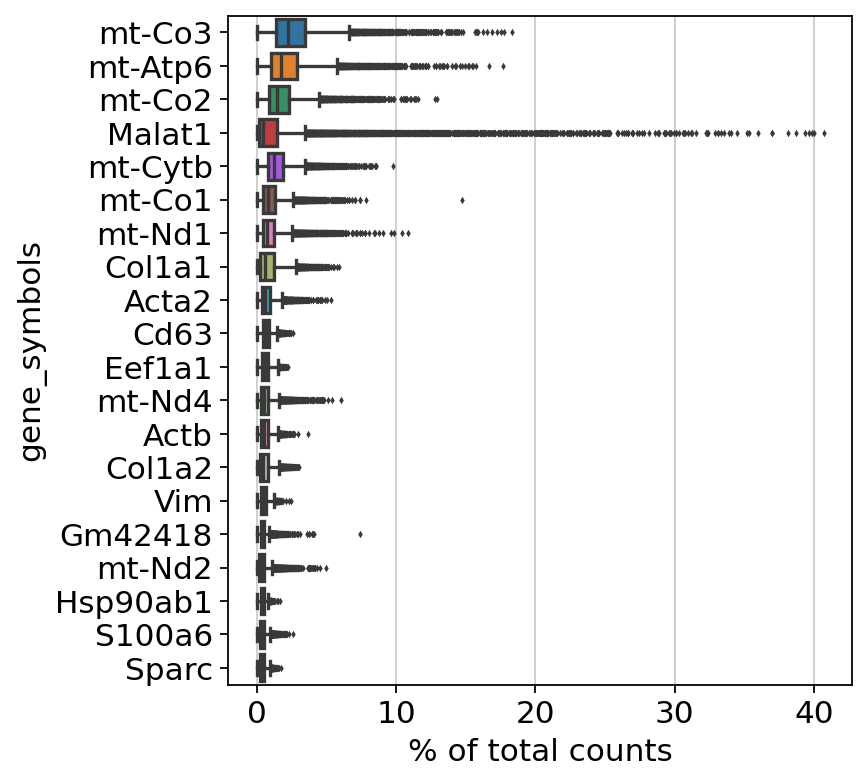

In [35]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Filtering

In [36]:
# Perform basic filtering
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 11554 genes that are detected in less than 3 cells


In [37]:
# Evaluate thresholds for quality control based on the following metrics for each cell:
#   % of counts from mitochondrial genes
#   total # counts
#   # genes expressed
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

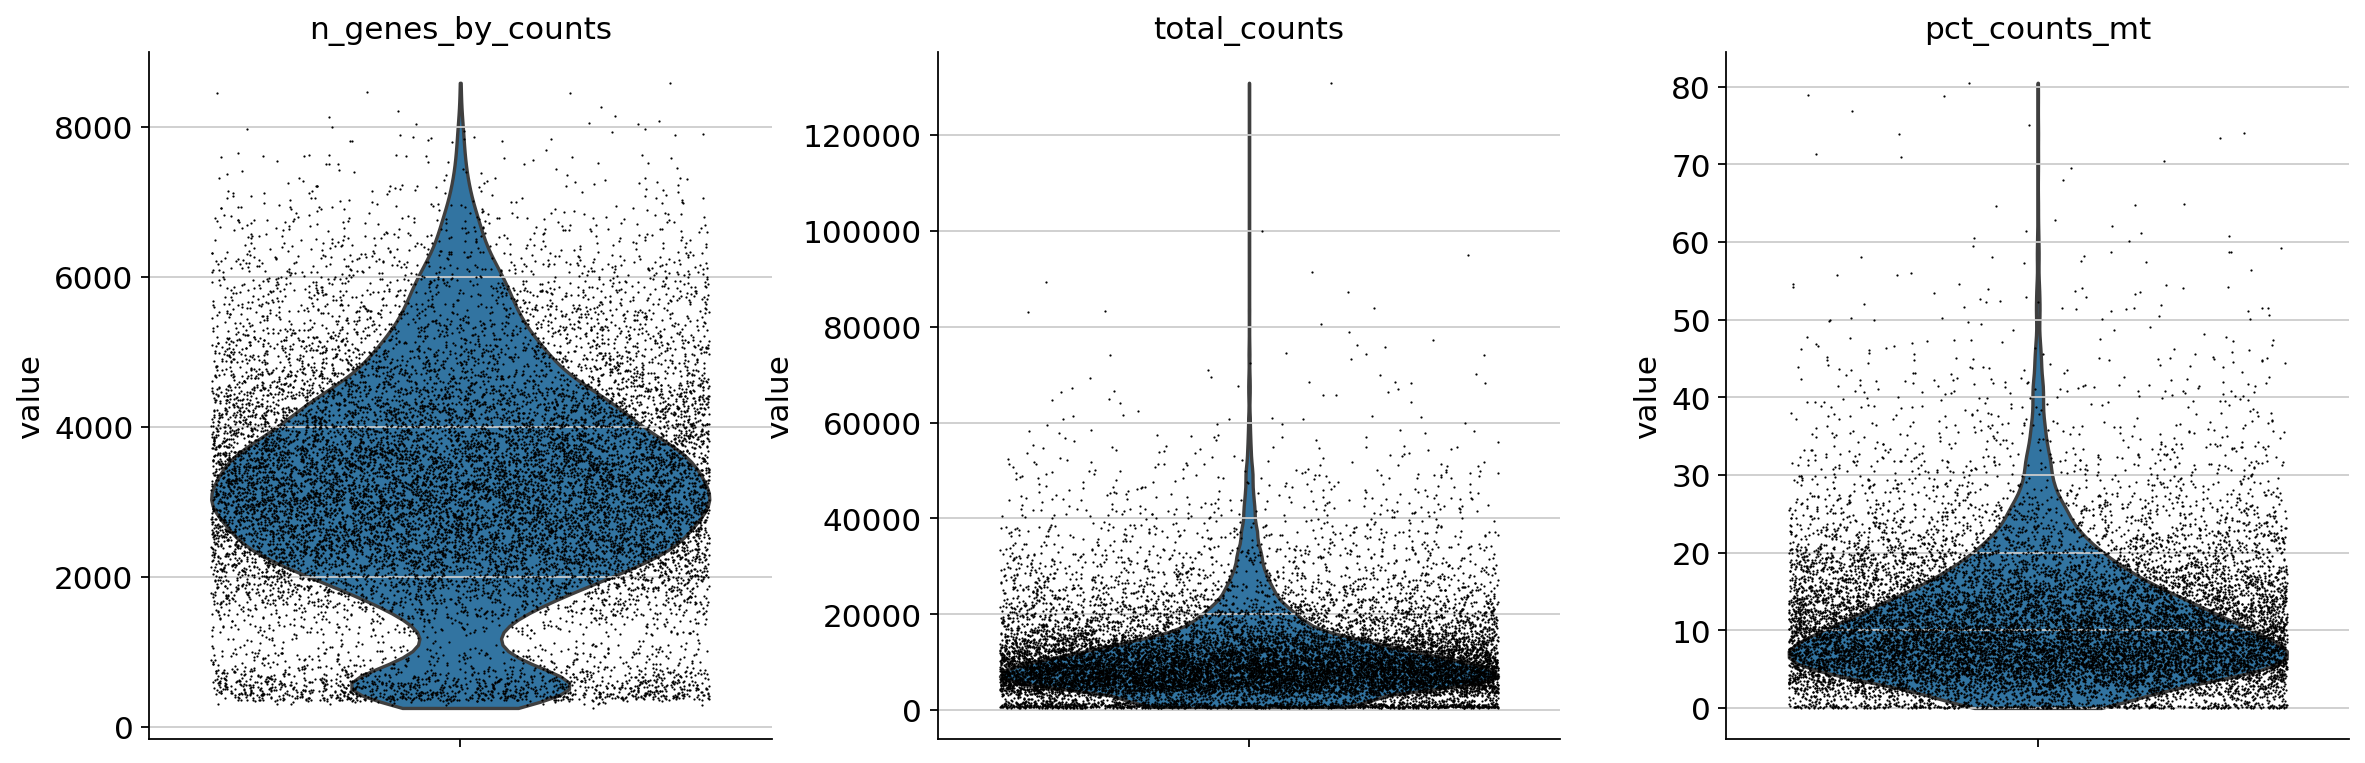

In [38]:
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)


Some general observations
* Recall that CellRanger does some filtering, and we did a bit of additional filtering above
* We would like to filter out samples with very high `total_counts`, since these are unlikely to be single cells
* There are many genes with a very high percentage of mitochondrial counts. This could indicate a high metabolic activity and/or a lower sample quality. We will play it safe and only exclude samples with very high fractions. Let's take a closer look.

Text(0, 0.5, 'Number of cells')

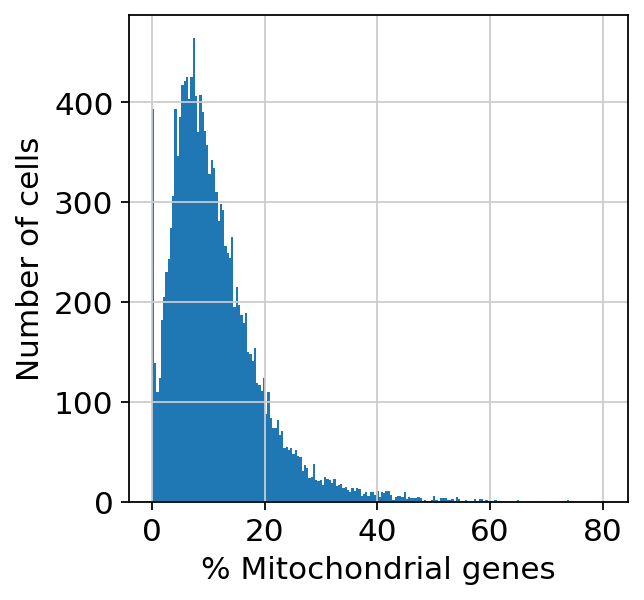

In [40]:
# Plot a histogram of the percent of counts from mitochondrial genes
plt.hist(adata.obs.pct_counts_mt, bins=200)
plt.xlabel("% Mitochondrial genes")
plt.ylabel("Number of cells")

<Figure size 320x320 with 0 Axes>

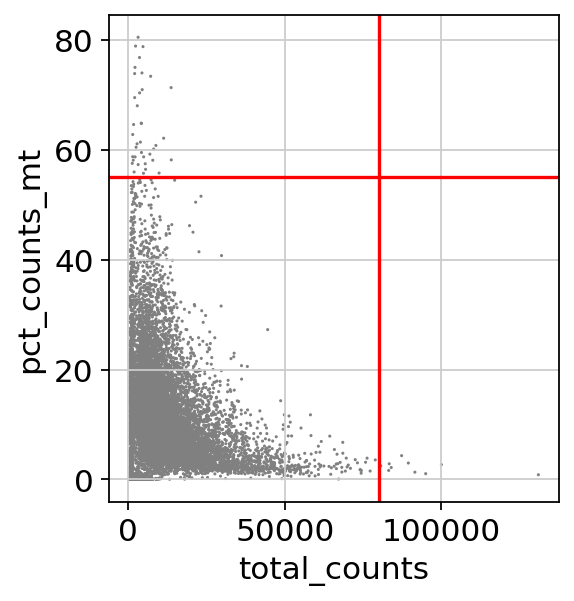

<Figure size 320x320 with 0 Axes>

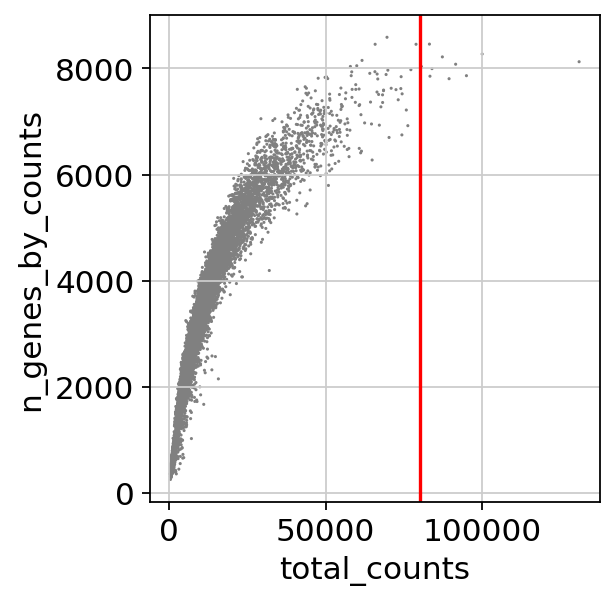

In [22]:
# Set a thresholds for total counts to exclude possible doublets
total_counts_thresh = 80_000

# Set a threshold for mitochondrial gene content to exclude possible dying cells
mt_pct_thresh = 55

# Plot covariate information
fig = plt.figure()
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False)
plt.axhline(y=mt_pct_thresh, color='red');
plt.axvline(x=total_counts_thresh, color='red');

fig = plt.figure()
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=False)
plt.axvline(x=total_counts_thresh, color='red');

In [23]:
# Perform additional filtering
adata = adata[adata.obs['total_counts'] < total_counts_thresh, :]
adata = adata[adata.obs['pct_counts_mt'] < mt_pct_thresh, :]

## Normalization

In [24]:
# Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data for fold-change analysis
sc.pp.log1p(adata)

normalizing counts per cell


/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


## Additional preprocessing

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


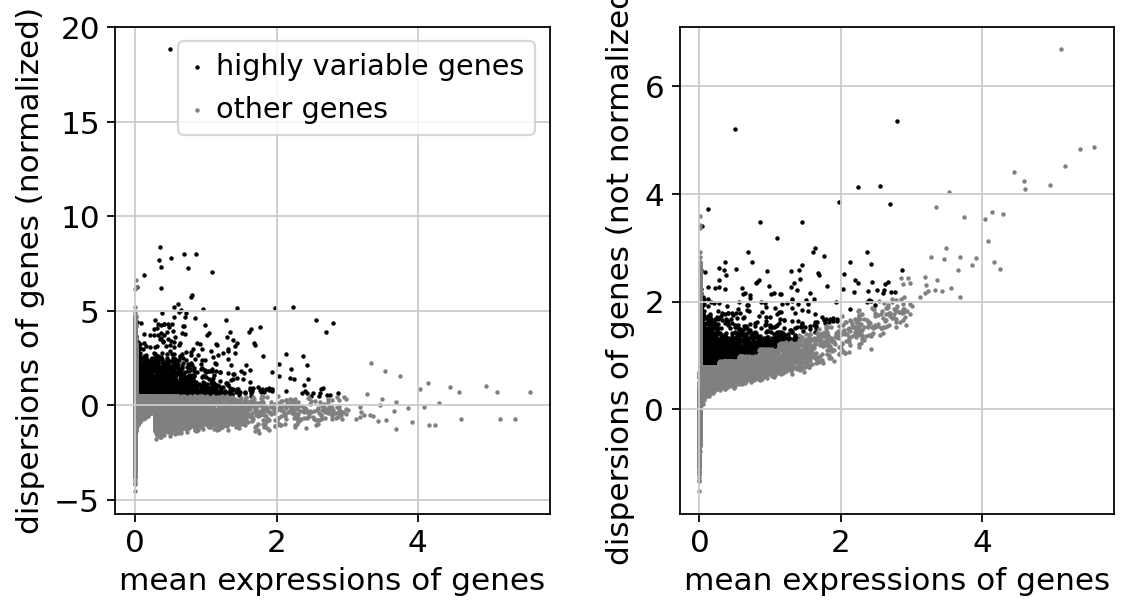

<Figure size 320x320 with 0 Axes>

In [26]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot
sc.pl.highly_variable_genes(adata)

In [27]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
adata.raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale the data to unit variance and clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:28)


# Sample B

In [28]:
sample_dir = data_dir.joinpath(
    "samples_B/outs/count/filtered_feature_bc_matrix"
    # "samples_A/outs/count/filtered_feature_bc_matrix"
)

# Read in the data
X = mmread(sample_dir.joinpath("matrix.mtx.gz")).T.tocsr()
barcodes = pd.read_csv(sample_dir.joinpath("barcodes.tsv.gz"), header=None, index_col=0, delimiter="\t")
genes = pd.read_csv(sample_dir.joinpath("features.tsv.gz"), header=None, index_col=1, delimiter="\t")
adata = sc.AnnData(X=X, obs=barcodes, var=genes)

# Rename the variable columns and index to be more informative
adata.var.rename(columns={0: "gene_ids", 2: "feature_types"}, inplace=True)
adata.var.rename_axis("gene_symbols", inplace=True)
adata.var_names_make_unique()

# Peek at the AnnData object
print(adata)
print("\nadata.var:")
print(adata.var)
print("\nadata.obs:")
print(adata.obs)

AnnData object with n_obs × n_vars = 22623 × 32285
    var: 'gene_ids', 'feature_types'

adata.var:
                        gene_ids    feature_types
gene_symbols                                     
Xkr4          ENSMUSG00000051951  Gene Expression
Gm1992        ENSMUSG00000089699  Gene Expression
Gm19938       ENSMUSG00000102331  Gene Expression
Gm37381       ENSMUSG00000102343  Gene Expression
Rp1           ENSMUSG00000025900  Gene Expression
...                          ...              ...
AC124606.1    ENSMUSG00000095523  Gene Expression
AC133095.2    ENSMUSG00000095475  Gene Expression
AC133095.1    ENSMUSG00000094855  Gene Expression
AC234645.1    ENSMUSG00000095019  Gene Expression
AC149090.1    ENSMUSG00000095041  Gene Expression

[32285 rows x 2 columns]

adata.obs:
Empty DataFrame
Columns: []
Index: [AAACCCAAGAGCAAGA-1, AAACCCAAGGAATCGC-1, AAACCCAAGGCCATAG-1, AAACCCAAGGGCCCTT-1, AAACCCACACGATAGG-1, AAACCCACATGAATAG-1, AAACCCAGTTGATGTC-1, AAACCCATCATTGCGA-1, AAACCCATCGAACTCA

/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell


    finished (0:00:00)


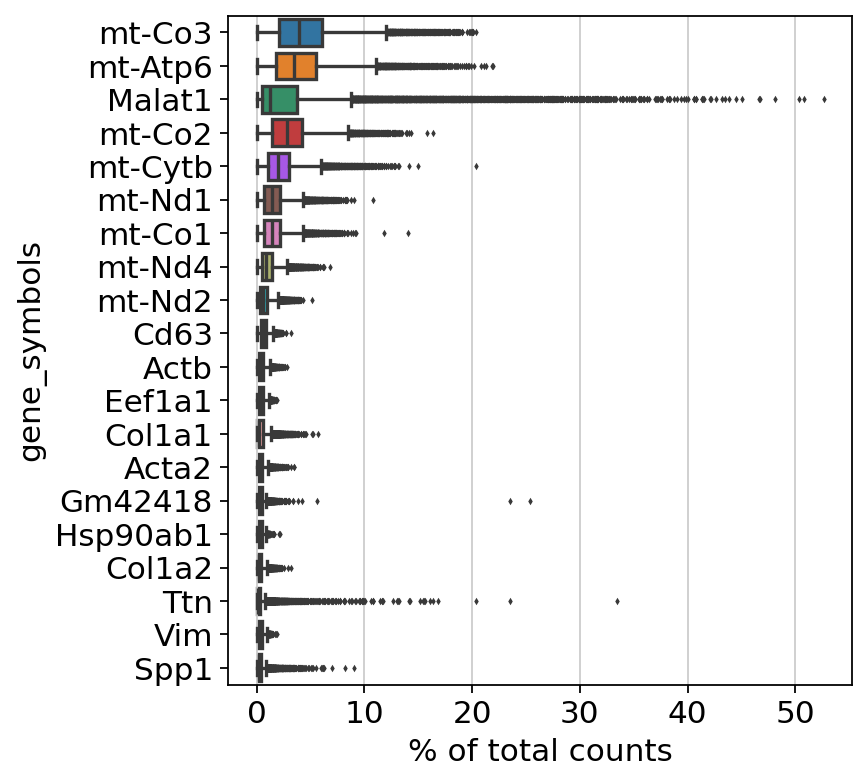

In [29]:
sc.pl.highest_expr_genes(adata, n_top=20)

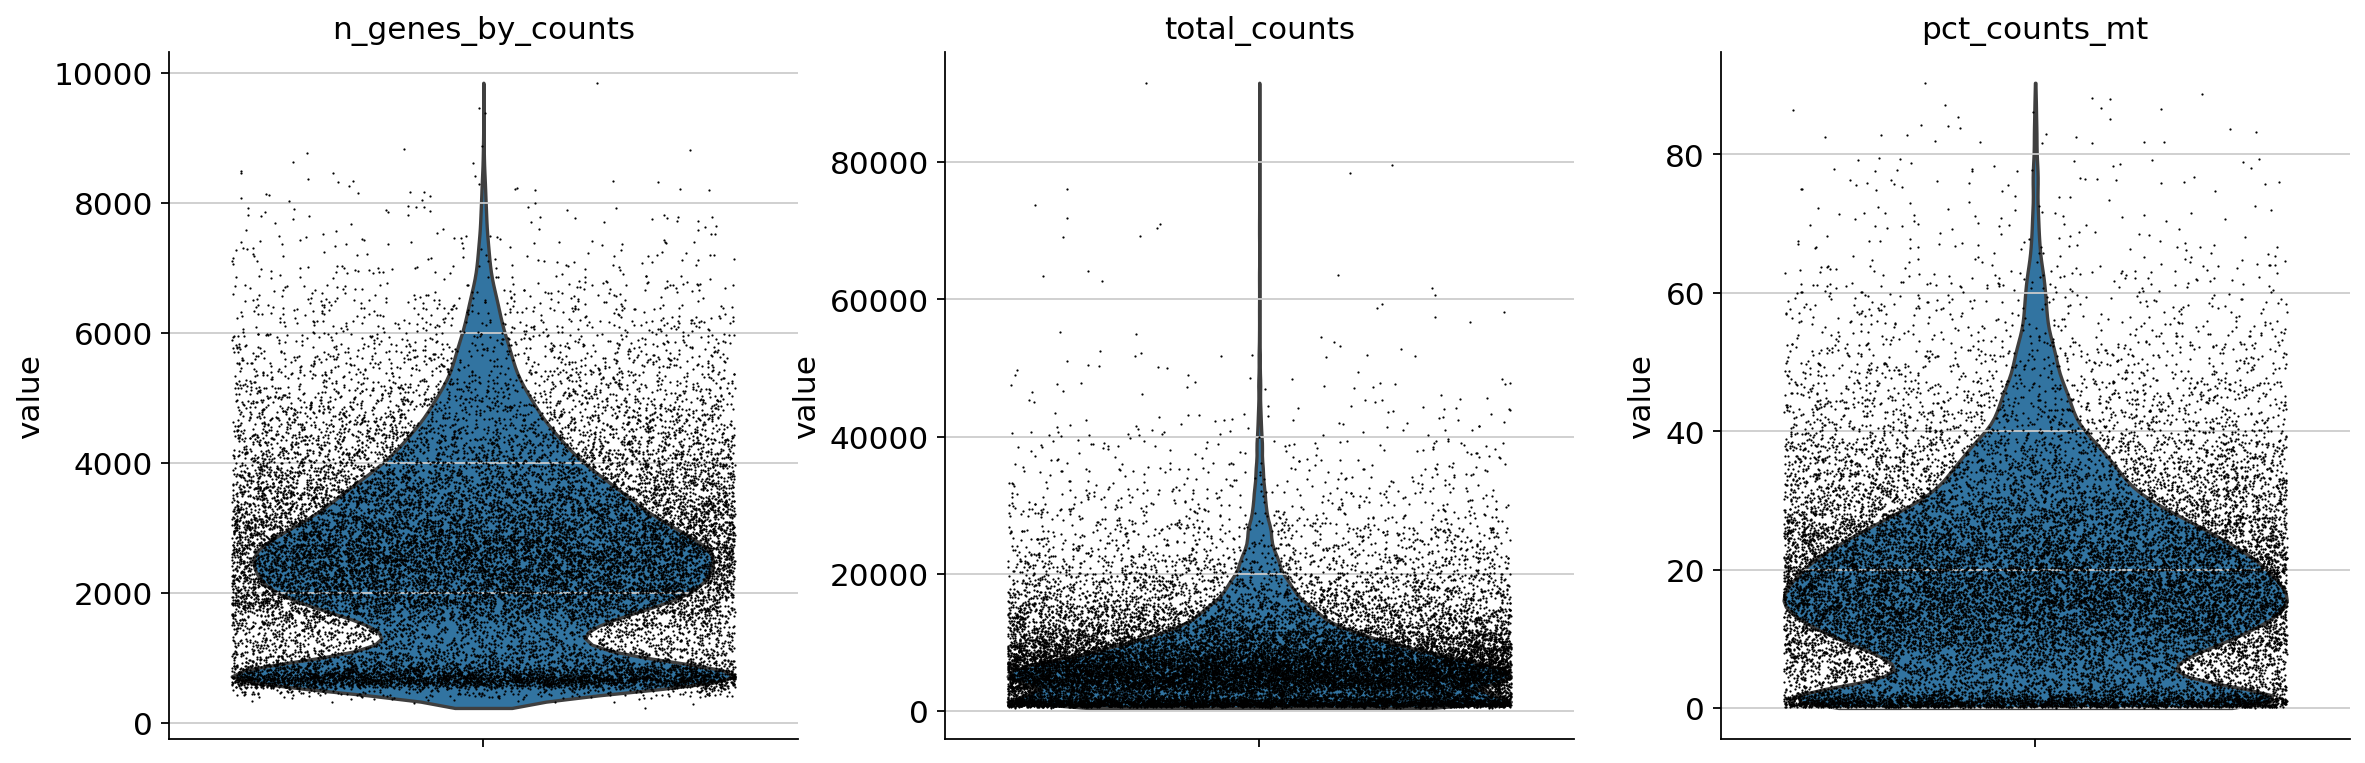

In [31]:
# Perform basic filtering
sc.pp.filter_cells(adata, min_genes=50)
sc.pp.filter_genes(adata, min_cells=3)

# Evaluate thresholds for quality control based on the following metrics for each cell:
#   % of counts from mitochondrial genes
#   total # counts
#   # genes expressed
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata, 
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=True
)


<Figure size 320x320 with 0 Axes>

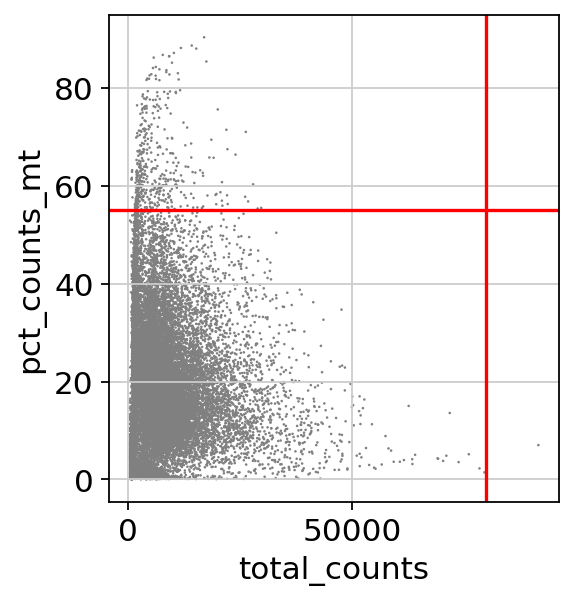

<Figure size 320x320 with 0 Axes>

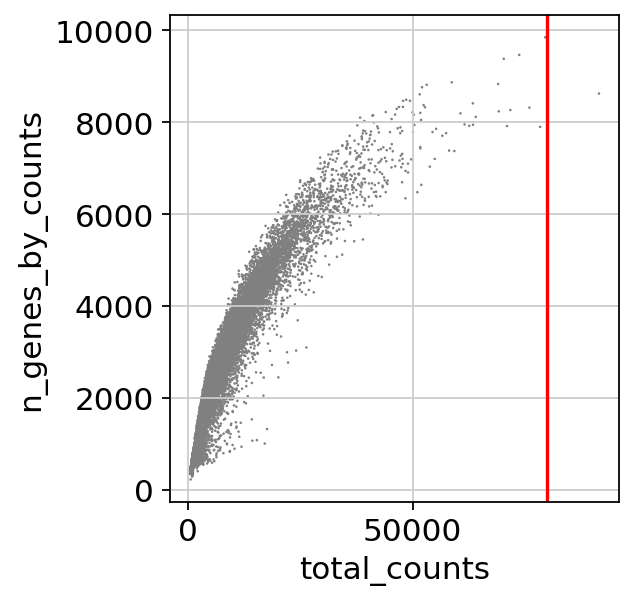

In [32]:
# # Set a thresholds for total counts to exclude possible doublets
# total_counts_thresh = 80_000

# # Set a threshold for mitochondrial gene content to exclude possible dying cells
# mt_pct_thresh = 55

# Plot covariate information
fig = plt.figure()
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False)
# plt.axhline(y=mt_pct_thresh, color='red');
# plt.axvline(x=total_counts_thresh, color='red');

fig = plt.figure()
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', show=False)
# plt.axvline(x=total_counts_thresh, color='red');

In [ ]:
# # Perform additional filtering
# adata = adata[adata.obs['total_counts'] < total_counts_thresh, :]
# adata = adata[adata.obs['pct_counts_mt'] < mt_pct_thresh, :]

## Normalization

In [ ]:
# Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data for fold-change analysis
sc.pp.log1p(adata)

normalizing counts per cell


/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


## Additional preprocessing

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


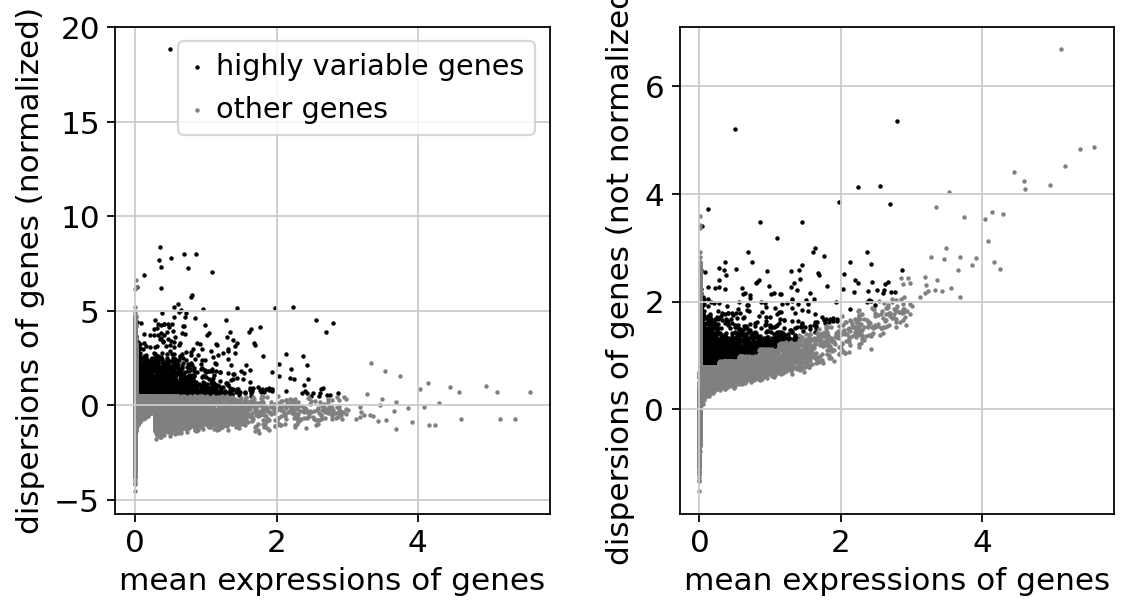

<Figure size 320x320 with 0 Axes>

In [ ]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Plot
sc.pl.highly_variable_genes(adata)

In [ ]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
adata.raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale the data to unit variance and clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:02:28)


----

In [2]:
# data_dir = Path('data/alignment/all_samples_aggr/outs/count/filtered_feature_bc_matrix')
# data_dir = Path('data/alignment/run_count_bwmt07-A1/outs/filtered_feature_bc_matrix')
# data_dir.exists()

True

In [3]:
# data_h5 = data_dir.parent.joinpath("filtered_feature_bc_matrix.h5")

# with h5py.File(data_h5, 'r') as f:
#     print(list(f.keys()))
#     print(f['matrix'].keys())
#     vals = f['matrix/data'][()]
#     idx = f['matrix/indices'][()]
#     indptr = f['matrix/indptr'][()]
#     shape = f['matrix/shape'][()]

#     gene_names = f['matrix/features/name'][()]
#     barcodes = f['matrix/barcodes'][()]

    # features = f['matrix/features']
    # barcodes = f['matrix/barcodes']

# mtx = csr_matrix((vals, idx, indptr), shape=shape)

In [4]:
# Load the matrix of counts
mtx = mmread(data_dir.joinpath("matrix.mtx.gz")).T.tocsr().astype(np.uint16)

# Load the barcodes and genes
barcodes = pd.read_csv(data_dir.joinpath("barcodes.tsv.gz"), header=None, sep='\t')
gene_list = pd.read_csv(data_dir.joinpath("features.tsv.gz"), header=None, sep='\t')
gene_list.columns = ['gene_id', 'gene_name', 'gene_type']

In [5]:
# Set the barcodes and genes as the index of the matrix
# Then construct the AnnData object

adata = sc.AnnData(X=mtx, obs=barcodes, var=gene_list)

/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [32]:
gene_names = np.array([x.decode('utf-8') for x in gene_names])
gene_names.shape

(32285,)

In [23]:
from scipy.sparse import csr_matrix

# mtx = csr_matrix((vals, idx, [0, 3, 6]), shape=(3, 3))

In [21]:
adata = sc.read_10x_mtx(
    path=data_dir,
    var_names='gene_symbols',
    cache=True,
    # cache=False,
)

... writing an h5ad cache file to speedup reading next time


/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [22]:
# print(adata)
print(adata.var_names.value_counts())


Gm1992    32285
Name: count, dtype: int64


In [6]:
import pandas as pd

pd.Series(adata.X.data).describe()

count    225995.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

In [12]:
adata.X.data.size / (adata.X.shape[0] * adata.X.shape[1])

8.326889906619877e-05

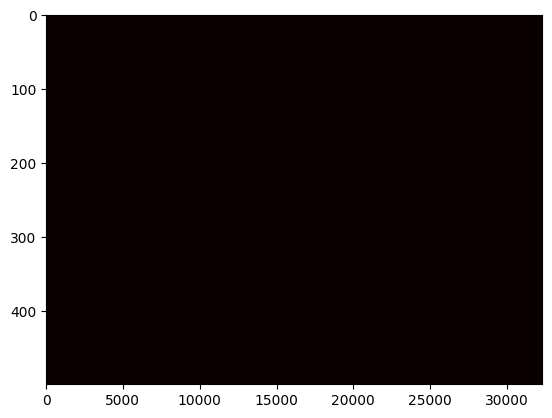

In [14]:
plt.imshow(adata.X[-500:].toarray(), aspect='auto', cmap='hot')

In [5]:
adata.obs

""
AAACCCAAGCTATCTG-1
AAACCCAAGGCTATCT-1
AAACCCACACAACATC-1
AAACCCACACCCTATC-1
AAACCCACAGCTGTAT-1
...
TTTGTTGGTGCGTTTA-8
TTTGTTGGTGGCAGAT-8
TTTGTTGTCAGCTTCC-8
TTTGTTGTCCCGAGTG-8


In [35]:
print(adata.var_names)

Index(['Gm1992', 'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992',
       'Gm1992', 'Gm1992', 'Gm1992',
       ...
       'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992', 'Gm1992',
       'Gm1992', 'Gm1992', 'Gm1992'],
      dtype='object', length=32285)


In [29]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

KeyboardInterrupt: 

normalizing counts per cell
    finished (0:00:00)


/home/ec2-user/.cache/pypoetry/virtualenvs/synnotch-materials-UCKvQ2bL-py3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


KeyboardInterrupt: 

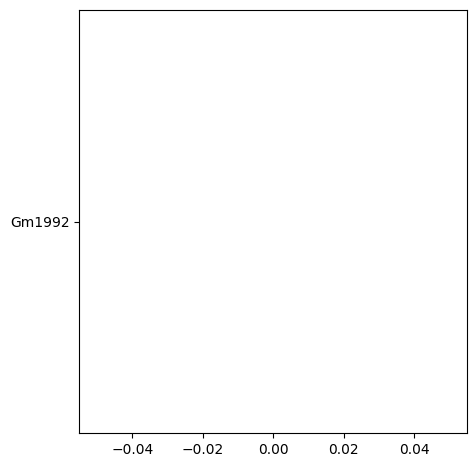

In [28]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [19]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 84058 cells that have less than 200 genes expressed


normalizing counts per cell
    finished (0:00:00)


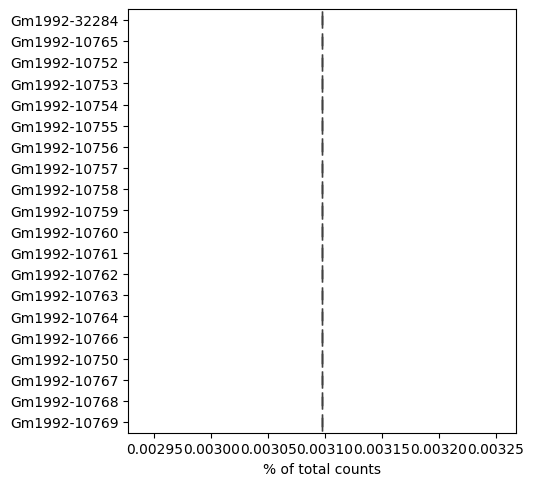

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, )